Data loading

In [87]:
from google.colab import files
uploaded = files.upload()

Saving D&O.csv to D&O (1).csv


Load libraries

In [88]:
import numpy as np
import io
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv(io.BytesIO(uploaded['D&O.csv']), index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-28,0.390,0.495,0.390,0.46,0.425383,77841700.0
2004-12-29,0.465,0.510,0.460,0.50,0.462373,19786600.0
2004-12-30,0.500,0.510,0.475,0.48,0.443878,6846700.0
2004-12-31,0.485,0.510,0.480,0.49,0.453125,8420300.0
2005-01-03,0.500,0.520,0.485,0.51,0.471620,7385000.0
...,...,...,...,...,...,...
2021-05-19,4.350,4.420,4.040,4.11,4.110000,12099800.0
2021-05-20,4.190,4.330,4.000,4.04,4.040000,9428200.0
2021-05-21,4.140,4.290,3.920,4.20,4.200000,9529800.0


Check for missing values

<function matplotlib.pyplot.show>

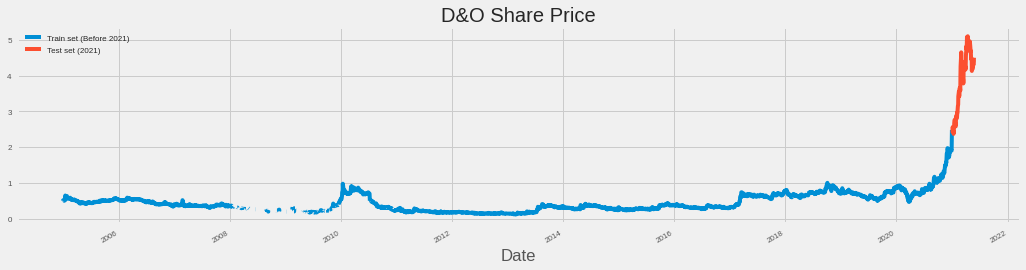

In [90]:
df['High'][:'2020'].plot(figsize=(16,4),legend=True)
df['High']['2021':].plot(figsize=(16,4),legend=True)
plt.legend(['Train set (Before 2021)', 'Test set (2021)'])
plt.title('D&O Share Price')
plt.show

In [92]:
train = df[:'2020'].iloc[:, 1:2].values
test = df['2021':].iloc[:, 1:2].values

Data Preprocessing

In [93]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_dataset = minMaxScaler.fit_transform(train)

In [95]:
X_train = []
y_train = []

for i in range(400, 3672):
  X_train.append(train_scaled_dataset[i - 400:i, 0])
  y_train.append(train_scaled_dataset[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [96]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### LSTM (Long Short-term Memory)

In [100]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
103/103 [==============================] - 89s 788ms/step - loss: 0.0053
Epoch 2/50
103/103 [==============================] - 82s 792ms/step - loss: 0.0014
Epoch 3/50
103/103 [==============================] - 82s 797ms/step - loss: 0.0014
Epoch 4/50
103/103 [==============================] - 83s 802ms/step - loss: 0.0013
Epoch 5/50
103/103 [==============================] - 82s 793ms/step - loss: 9.2462e-04
Epoch 6/50
103/103 [==============================] - 82s 794ms/step - loss: 9.7271e-04
Epoch 7/50
103/103 [==============================] - 81s 783ms/step - loss: 7.8656e-04
Epoch 8/50
103/103 [==============================] - 82s 792ms/step - loss: 6.8742e-04
Epoch 9/50
103/103 [==============================] - 83s 805ms/step - loss: 7.6646e-04
Epoch 10/50
103/103 [==============================] - 82s 800ms/step - loss: 8.9705e-04
Epoch 11/50
103/103 [==============================] - 78s 755ms/step - loss: 7.6373e-04
Epoch 12/50
103/103 [=========================

In [102]:
df_total = pd.concat((df['High'][:'2020'], df['High']['2021':]), axis=0)
inputs = df_total[len(df_total) - len(test) - 400:].values
inputs = inputs.reshape(-1, 1)
inputs  = minMaxScaler.transform(inputs)

In [103]:
inputs.shape

(496, 1)

In [104]:
X_test = []

for i in range(400, 496):
  X_test.append(inputs[i - 400:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = minMaxScaler.inverse_transform(predicted_stock_price)

In [70]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real D&O Stock Price')
    plt.plot(predicted, color='blue', label='Predicted D&O Stock Price')
    plt.title('D&O Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('D&O Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print('The root mean squared error is {}.'.format(rmse))

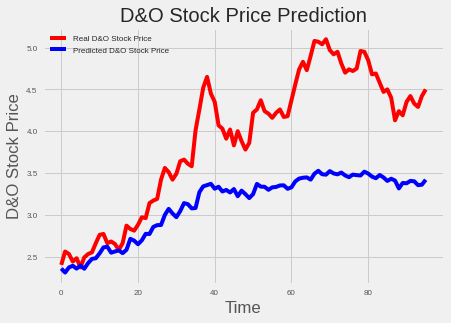

In [105]:
plot_predictions(test, predicted_stock_price)

In [107]:
return_rmse(test, predicted_stock_price)

The root mean squared error is 0.9038359517876032.


### GRU (Gated Recurrent Units)

In [108]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
22/22 [==============================] - 42s 1s/step - loss: 0.0239
Epoch 2/50
22/22 [==============================] - 32s 1s/step - loss: 0.0166
Epoch 3/50
22/22 [==============================] - 32s 1s/step - loss: 0.0122
Epoch 4/50
22/22 [==============================] - 32s 1s/step - loss: 0.0107
Epoch 5/50
22/22 [==============================] - 32s 1s/step - loss: 0.0090
Epoch 6/50
22/22 [==============================] - 33s 1s/step - loss: 0.0073
Epoch 7/50
22/22 [==============================] - 32s 1s/step - loss: 0.0053
Epoch 8/50
22/22 [==============================] - 33s 1s/step - loss: 0.0035
Epoch 9/50
22/22 [==============================] - 32s 1s/step - loss: 0.0021
Epoch 10/50
22/22 [==============================] - 33s 1s/step - loss: 0.0012
Epoch 11/50
22/22 [==============================] - 32s 1s/step - loss: 8.0455e-04
Epoch 12/50
22/22 [==============================] - 33s 1s/step - loss: 7.1762e-04
Epoch 13/50
22/22 [======================

In [109]:
X_test = []

for i in range(400, 496):
  X_test.append(inputs[i - 400:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = minMaxScaler.inverse_transform(GRU_predicted_stock_price)

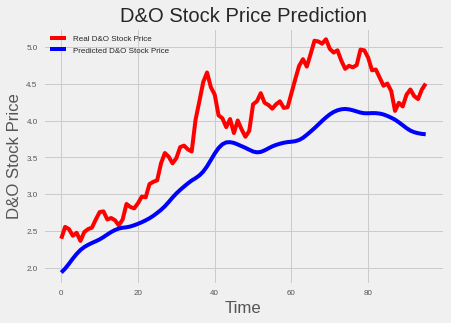

In [110]:
plot_predictions(test, GRU_predicted_stock_price)

In [111]:
return_rmse(test, GRU_predicted_stock_price)

The root mean squared error is 0.6076314319832479.
